# Máster en Big Data y Data Science

## Metodologías de gestión y diseño de proyectos big data

### AP1 - Preparación de los Datos

#### Selección de Datos

##### Importación de librerías y configuración del notebook

In [1]:
# Importacion de las librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import datetime

In [2]:
# CFG Notebook
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows = None
pd.options.display.max_columns = None
plt.rc('figure',figsize=(15,8))

##### Carga y visualización de primeros registros

In [3]:
df_creditos = pd.read_csv("../../data/processed/datos_creditos_v1.csv", delimiter = ";")
df_tarjetas = pd.read_csv("../../data/processed/datos_tarjetas_v1.csv", delimiter = ";")

In [4]:
display(df_creditos.sample(2), df_tarjetas.sample(2))

,id_cliente,edad,importe_solicitado,duracion_credito,antiguedad_empleado,situacion_vivienda,ingresos,objetivo_credito,pct_ingreso,tasa_interes,estado_credito,falta_pago
4274,797748708.0,23,4000,3,NaN,HIPOTECA,40000,EDUCACIÓN,0.10,6.39,0,N
5153,716256483.0,24,2000,3,8.0,HIPOTECA,44000,EDUCACIÓN,0.05,5.79,0,N


,id_cliente,antiguedad_cliente,estado_civil,estado_cliente,gastos_ult_12m,genero,limite_credito_tc,nivel_educativo,nivel_tarjeta,operaciones_ult_12m,personas_a_cargo
3320,708665133.0,28.0,CASADO,ACTIVO,4003.0,M,3654.0,UNIVERSITARIO_COMPLETO,Blue,67.0,2.0
3222,758833758.0,38.0,CASADO,ACTIVO,3520.0,M,1862.0,DESCONOCIDO,Blue,68.0,4.0


**Operaciones a realizar**

1. Selección de columnas
2. Limpieza de datos
3. Integración de datasets
4. Transformaciñon de atributos
5. Formateo definitivo

##### Datos créditos

| Columna               | Acción                                       |
|-----------------------|---------------------------------------------------------|
| `id_cliente`          | Conservar|
| `edad`                | Conservar|
| `importe_solicitado`  | Conservar|
| `duracion_credito`    | Conservar|
| `antiguedad_empleado` | Conservar, con tratamiento de nulos|
| `situacion_vivienda`  | Conservar, evaluar codificación|
| `ingresos`            | Conservar|
| `objetivo_credito`    | Conservar, eventual agrupación de categorías|
| `pct_ingreso`         | evaluar regla|
| `tasa_interes`        | Conservar, con tratamiento de nulos|
| `estado_credito`      | Conservar como variable objetivo|
| `falta_pago`          | Evaluar redundancia con `estado_credito`|

<Axes: >

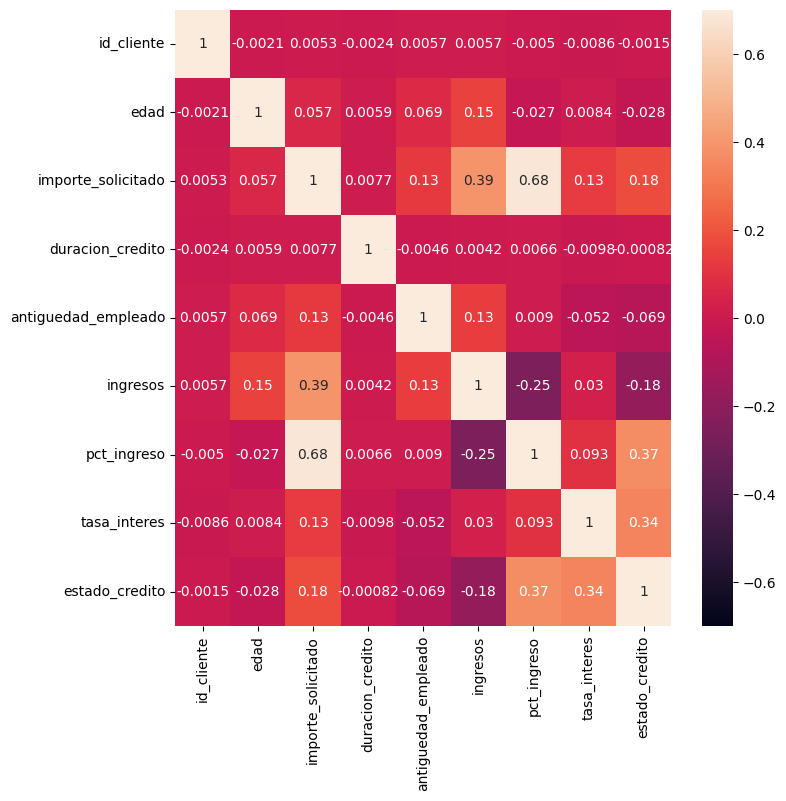

In [5]:
## Análisis de Correlación de variables numéricas
plt.figure(figsize=(8,8))
mat_corr_cred = df_creditos.select_dtypes(include='number').corr()
sns.heatmap(mat_corr_cred, vmin=-0.7, vmax = 0.7, annot = True)

***No se observan correlaciones significativas (-0.7 < corr < 0.7 ) entre las variables numéricas del dataset de créditos***

##### Datos tarjetas

| Columna               | Acciónn |
|-----------------------|------------|
| `id_cliente`          | Conservar|
| `antiguedad_cliente`  | Conservar|
| `estado_civil`        | Conservar, evaluar codificación|
| `estado_cliente`      | Conservar|
| `gastos_ult_12m`      | Conservar|
| `genero`              | Conservar, evaluar codificación|
| `limite_credito_tc`   | Conservar|
| `nivel_educativo`     | Conservar, considerar agrupar categorías|
| `nivel_tarjeta`       | correlación límite|
| `operaciones_ult_12m` | Conservar|
| `personas_a_cargo`    | Conservar|

***Se elimina la columna `nivel_tarjeta` del dataset de tarjetas, dada su alta correlación -- a nivel de definición de negocio -- con la variable monto límite de la misma***

<Axes: >

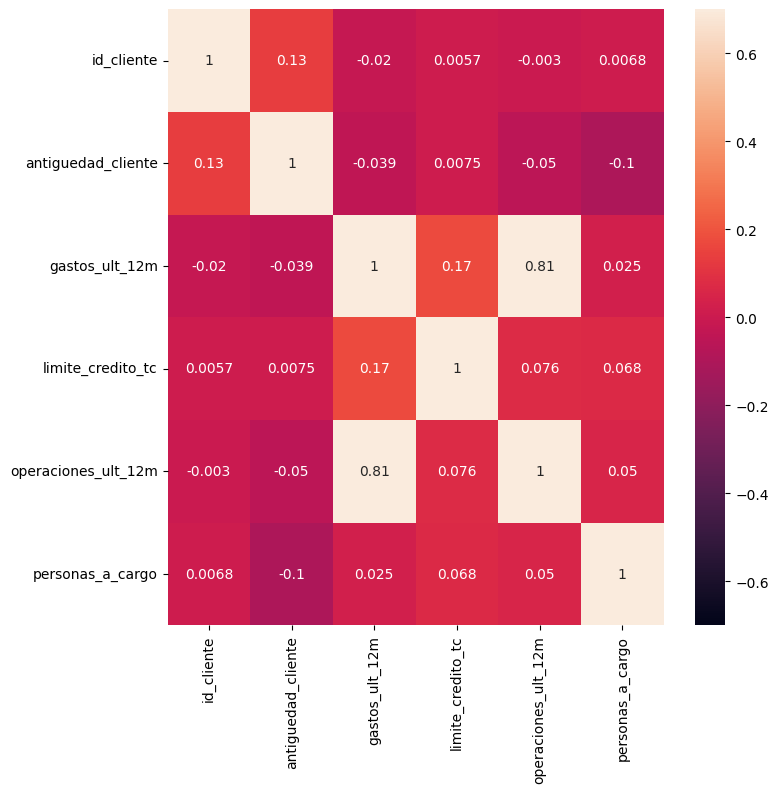

In [6]:
## Análisis de Correlación de variables
plt.figure(figsize=(8,8))
mat_corr_tarjetas = df_tarjetas.select_dtypes(include='number').corr()
sns.heatmap(mat_corr_tarjetas, vmin=-0.7, vmax = 0.7, annot = True)

***De acuerdo con la amtriz de correlación, se observa que las variables `operaciones_ult_12_m` y `gastos_ult_12_m` se encuestran altamente correlacionadas, por lo que eventualmente cuando se aplique modelamiento predictivo, ambas variables aportan info similar y pueden surgir problemas de colinealidad, por lo tanto se eliminará una***

In [7]:
# Eliminación de columnass identificadas
df_tarjetas.drop(columns = ["nivel_tarjeta", "operaciones_ult_12m"], inplace = True)

In [8]:
df_tarjetas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id_cliente          10127 non-null  float64
 1   antiguedad_cliente  10127 non-null  float64
 2   estado_civil        10127 non-null  object 
 3   estado_cliente      10127 non-null  object 
 4   gastos_ult_12m      10127 non-null  float64
 5   genero              10127 non-null  object 
 6   limite_credito_tc   10127 non-null  float64
 7   nivel_educativo     10127 non-null  object 
 8   personas_a_cargo    10127 non-null  float64
dtypes: float64(5), object(4)
memory usage: 712.2+ KB


#### Limpieza de Datos

In [9]:
### Primera Regla
def regla_pct_ingresos_credito(row):
    pct_ingreso = row.pct_ingreso
    ingresos = row.ingresos
    
    if pct_ingreso > 0.5 and ingresos <= 20000:
        # Es un error, no cumple la regla definida
        return 'err'
    else:
        return 'ok'


regla_pct_ingresos = df_creditos.apply(lambda row: regla_pct_ingresos_credito(row), axis=1).rename("regla_pct_ingresos")
df_creditos = pd.concat([df_creditos, regla_pct_ingresos], axis=1)
df_creditos.head(5)  

,id_cliente,edad,importe_solicitado,duracion_credito,antiguedad_empleado,situacion_vivienda,ingresos,objetivo_credito,pct_ingreso,tasa_interes,estado_credito,falta_pago,regla_pct_ingresos
0,713061558.0,22,35000,3,123.0,ALQUILER,59000,PERSONAL,0.59,16.02,1,Y,ok
1,768805383.0,21,1000,2,5.0,PROPIA,9600,EDUCACIÓN,0.10,11.14,0,N,ok
2,818770008.0,25,5500,3,1.0,HIPOTECA,9600,SALUD,0.57,12.87,1,N,err
3,713982108.0,23,35000,2,4.0,ALQUILER,65500,SALUD,0.53,15.23,1,N,ok
4,710821833.0,24,35000,4,8.0,ALQUILER,54400,SALUD,0.55,14.27,1,Y,ok


In [50]:
df_creditos[df_creditos["regla_pct_ingresos"] == "err"]

,id_cliente,edad,importe_solicitado,duracion_credito,antiguedad_empleado,situacion_vivienda,ingresos,objetivo_credito,pct_ingreso,tasa_interes,estado_credito,falta_pago,regla_pct_ingresos,regla_duracion_credito
2,818770008.0,25,5500,3,1.0,HIPOTECA,9600,SALUD,0.57,12.87,1,N,err,ok
75,789973308.0,26,6100,3,2.0,PROPIA,12000,EDUCACIÓN,0.51,7.51,1,N,err,ok
160,718759833.0,23,7750,4,2.0,PROPIA,13920,PERSONAL,0.56,17.04,1,N,err,ok
460,717392358.0,24,13000,3,6.0,PROPIA,18000,PERSONAL,0.72,7.88,1,N,err,ok
469,711864783.0,24,10000,2,0.0,HIPOTECA,18000,PAGO_DEUDAS,0.56,12.18,1,N,err,ok
571,709040508.0,21,15000,2,0.0,HIPOTECA,19500,EDUCACIÓN,0.77,9.64,1,N,err,err
640,719428308.0,22,16600,3,0.0,HIPOTECA,20000,PERSONAL,0.83,9.76,0,N,err,ok
3487,779601783.0,26,10625,3,NaN,ALQUILER,16800,PERSONAL,0.63,NaN,1,N,err,ok
6758,713115483.0,22,7000,2,0.0,ALQUILER,10000,MEJORAS_HOGAR,0.70,12.21,1,N,err,err
7441,719373558.0,22,6700,4,0.0,ALQUILER,12000,EDUCACIÓN,0.56,7.66,1,N,err,ok


In [10]:
## Segunda regla
def regla_duracion_credito(row):
    duracion_credito = row.duracion_credito
    pct_ingreso = row.pct_ingreso
    situacion_vivienda = row.situacion_vivienda
    duracion_minima = df_creditos['duracion_credito'].min() # duración mínima
    
    # si la duración es mínima y el porcentaje de ingresos excede el 60%
    if duracion_credito == duracion_minima and pct_ingreso > 0.6:
        if situacion_vivienda != "PROPIA": # Solo si es propietario
            return 'err'
    return 'ok'

regla_duracion_credito_aplicada = df_creditos.apply(lambda row: regla_duracion_credito(row), axis=1).rename("regla_duracion_credito")
df_creditos = pd.concat([df_creditos, regla_duracion_credito_aplicada], axis=1)


In [11]:
## Reglas aplicadas
df_creditos.head(5) 

,id_cliente,edad,importe_solicitado,duracion_credito,antiguedad_empleado,situacion_vivienda,ingresos,objetivo_credito,pct_ingreso,tasa_interes,estado_credito,falta_pago,regla_pct_ingresos,regla_duracion_credito
0,713061558.0,22,35000,3,123.0,ALQUILER,59000,PERSONAL,0.59,16.02,1,Y,ok,ok
1,768805383.0,21,1000,2,5.0,PROPIA,9600,EDUCACIÓN,0.10,11.14,0,N,ok,ok
2,818770008.0,25,5500,3,1.0,HIPOTECA,9600,SALUD,0.57,12.87,1,N,err,ok
3,713982108.0,23,35000,2,4.0,ALQUILER,65500,SALUD,0.53,15.23,1,N,ok,ok
4,710821833.0,24,35000,4,8.0,ALQUILER,54400,SALUD,0.55,14.27,1,Y,ok,ok


In [51]:
df_creditos[df_creditos["regla_duracion_credito"] == "err"]

,id_cliente,edad,importe_solicitado,duracion_credito,antiguedad_empleado,situacion_vivienda,ingresos,objetivo_credito,pct_ingreso,tasa_interes,estado_credito,falta_pago,regla_pct_ingresos,regla_duracion_credito
36,713962233.0,22,30000,2,1.0,ALQUILER,48000,EDUCACIÓN,0.63,18.39,1,N,ok,err
571,709040508.0,21,15000,2,0.0,HIPOTECA,19500,EDUCACIÓN,0.77,9.64,1,N,err,err
577,716027208.0,26,20050,2,10.0,ALQUILER,26000,EDUCACIÓN,0.77,9.76,1,N,ok,err
587,709186983.0,23,20000,2,1.0,ALQUILER,32900,EDUCACIÓN,0.61,16.00,1,N,ok,err
3535,717886008.0,24,25000,2,4.0,HIPOTECA,37000,SALUD,0.68,10.08,0,N,ok,err
6758,713115483.0,22,7000,2,0.0,ALQUILER,10000,MEJORAS_HOGAR,0.70,12.21,1,N,err,err
7220,711399408.0,24,29100,2,8.0,HIPOTECA,46000,PERSONAL,0.63,12.99,1,Y,ok,err


In [12]:
df_creditos_err = df_creditos[(df_creditos['regla_pct_ingresos'] == 'err') | (df_creditos['regla_duracion_credito'] == 'err')].copy()

In [13]:
df_creditos_err.shape

(20, 14)

In [14]:
df_creditos_err

,id_cliente,edad,importe_solicitado,duracion_credito,antiguedad_empleado,situacion_vivienda,ingresos,objetivo_credito,pct_ingreso,tasa_interes,estado_credito,falta_pago,regla_pct_ingresos,regla_duracion_credito
2,818770008.0,25,5500,3,1.0,HIPOTECA,9600,SALUD,0.57,12.87,1,N,err,ok
36,713962233.0,22,30000,2,1.0,ALQUILER,48000,EDUCACIÓN,0.63,18.39,1,N,ok,err
75,789973308.0,26,6100,3,2.0,PROPIA,12000,EDUCACIÓN,0.51,7.51,1,N,err,ok
160,718759833.0,23,7750,4,2.0,PROPIA,13920,PERSONAL,0.56,17.04,1,N,err,ok
460,717392358.0,24,13000,3,6.0,PROPIA,18000,PERSONAL,0.72,7.88,1,N,err,ok
469,711864783.0,24,10000,2,0.0,HIPOTECA,18000,PAGO_DEUDAS,0.56,12.18,1,N,err,ok
571,709040508.0,21,15000,2,0.0,HIPOTECA,19500,EDUCACIÓN,0.77,9.64,1,N,err,err
577,716027208.0,26,20050,2,10.0,ALQUILER,26000,EDUCACIÓN,0.77,9.76,1,N,ok,err
587,709186983.0,23,20000,2,1.0,ALQUILER,32900,EDUCACIÓN,0.61,16.00,1,N,ok,err
640,719428308.0,22,16600,3,0.0,HIPOTECA,20000,PERSONAL,0.83,9.76,0,N,err,ok


In [15]:
## Filtro filas análisis de calidad
df_creditos.describe().T

,count,mean,std,min,25%,50%,75%,max
id_cliente,10127.0,7.391776e+08,3.690378e+07,7.080821e+08,713036770.5,7.179264e+08,7.731435e+08,8.283431e+08
edad,10127.0,2.357273e+01,2.664686e+00,2.000000e+01,22.0,2.300000e+01,2.500000e+01,1.440000e+02
importe_solicitado,10127.0,8.138733e+03,5.740107e+03,5.000000e+02,4425.0,6.500000e+03,1.000000e+04,3.500000e+04
duracion_credito,10127.0,2.995556e+00,8.172300e-01,2.000000e+00,2.0,3.000000e+00,4.000000e+00,4.000000e+00
antiguedad_empleado,9790.0,3.938509e+00,3.320165e+00,0.000000e+00,2.0,4.000000e+00,6.000000e+00,1.230000e+02
ingresos,10127.0,5.038190e+04,2.878554e+04,9.600000e+03,33600.0,4.600000e+04,5.979050e+04,5.000000e+05
pct_ingreso,10127.0,1.772262e-01,1.097840e-01,1.000000e-02,0.1,1.500000e-01,2.400000e-01,8.300000e-01
tasa_interes,9215.0,1.097943e+01,3.204760e+00,5.420000e+00,7.9,1.099000e+01,1.343000e+01,2.211000e+01
estado_credito,10127.0,2.460748e-01,4.307439e-01,0.000000e+00,0.0,0.000000e+00,0.000000e+00,1.000000e+00


In [16]:
## Variables con conflicto 
display(df_creditos["edad"].value_counts(), df_creditos["antiguedad_empleado"].value_counts())

edad
22     2228
23     2190
24     1926
25     1646
26     1328
21      799
20        6
144       2
123       2
Name: count, dtype: int64

antiguedad_empleado
0.0      1414
2.0      1281
3.0      1128
5.0      1050
6.0      1027
1.0       993
4.0       846
7.0       784
8.0       587
9.0       414
10.0      237
11.0       27
123.0       2
Name: count, dtype: int64

In [17]:
### Filtrado final 
df_creditos_filtrado = df_creditos[(df_creditos["edad"]<90) & (df_creditos["antiguedad_empleado"]<100) &
            (df_creditos["regla_pct_ingresos"] == 'ok') & (df_creditos["regla_duracion_credito"] == 'ok')].copy()

In [18]:
df_creditos_filtrado.sample(5)

,id_cliente,edad,importe_solicitado,duracion_credito,antiguedad_empleado,situacion_vivienda,ingresos,objetivo_credito,pct_ingreso,tasa_interes,estado_credito,falta_pago,regla_pct_ingresos,regla_duracion_credito
4727,711305208.0,24,5000,4,0.0,ALQUILER,29120,EDUCACIÓN,0.17,10.99,0,N,ok,ok
9151,711814608.0,24,5000,2,0.0,ALQUILER,13000,PAGO_DEUDAS,0.38,8.00,1,N,ok,ok
6988,708303108.0,25,4200,3,9.0,PROPIA,50988,MEJORAS_HOGAR,0.08,9.99,0,N,ok,ok
2828,715468083.0,25,3000,2,0.0,ALQUILER,50160,PAGO_DEUDAS,0.06,14.42,1,N,ok,ok
8668,711203658.0,23,8000,2,4.0,ALQUILER,30000,SALUD,0.27,12.18,0,N,ok,ok


In [19]:
df_tarjetas.describe().T

,count,mean,std,min,25%,50%,75%,max
id_cliente,10127.0,7.391776e+08,3.690378e+07,708082083.0,713036770.5,717926358.0,773143533.0,828343083.0
antiguedad_cliente,10127.0,3.592841e+01,7.986416e+00,13.0,31.0,36.0,40.0,56.0
gastos_ult_12m,10127.0,4.404086e+03,3.397129e+03,510.0,2155.5,3899.0,4741.0,18484.0
limite_credito_tc,10127.0,8.631954e+03,9.088777e+03,1438.3,2555.0,4549.0,11067.5,34516.0
personas_a_cargo,10127.0,2.346203e+00,1.298908e+00,0.0,1.0,2.0,3.0,5.0


#### Integración de Datos

In [20]:
df_integrado = pd.merge(df_creditos_filtrado, df_tarjetas, on='id_cliente', how='inner')
coincidencias = df_integrado.shape[0]

print(f"Filas del dataset integrado con los filtros realizados: {coincidencias}")
print(f"Cantidad de columnas del dataset integrado: {df_integrado.shape[1]}")

Filas del dataset integrado con los filtros realizados: 9765
Cantidad de columnas del dataset integrado: 22


#### Trnsformación de Datos

In [21]:
df_integrado.sample(2)

,id_cliente,edad,importe_solicitado,duracion_credito,antiguedad_empleado,situacion_vivienda,ingresos,objetivo_credito,pct_ingreso,tasa_interes,estado_credito,falta_pago,regla_pct_ingresos,regla_duracion_credito,antiguedad_cliente,estado_civil,estado_cliente,gastos_ult_12m,genero,limite_credito_tc,nivel_educativo,personas_a_cargo
4648,719464758.0,24,2000,2,2.0,HIPOTECA,42000,PERSONAL,0.05,11.28,0,N,ok,ok,43.0,SOLTERO,ACTIVO,4219.0,F,1438.3,UNIVERSITARIO_INCOMPLETO,1.0
9552,799253808.0,25,9000,3,9.0,ALQUILER,46500,SALUD,0.19,NaN,0,N,ok,ok,36.0,CASADO,ACTIVO,13845.0,M,34516.0,SECUNDARIO_COMPLETO,3.0


In [22]:
df_integrado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9765 entries, 0 to 9764
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id_cliente              9765 non-null   float64
 1   edad                    9765 non-null   int64  
 2   importe_solicitado      9765 non-null   int64  
 3   duracion_credito        9765 non-null   int64  
 4   antiguedad_empleado     9765 non-null   float64
 5   situacion_vivienda      9765 non-null   object 
 6   ingresos                9765 non-null   int64  
 7   objetivo_credito        9765 non-null   object 
 8   pct_ingreso             9765 non-null   float64
 9   tasa_interes            8878 non-null   float64
 10  estado_credito          9765 non-null   int64  
 11  falta_pago              9765 non-null   object 
 12  regla_pct_ingresos      9765 non-null   object 
 13  regla_duracion_credito  9765 non-null   object 
 14  antiguedad_cliente      9765 non-null   

In [23]:
df_integrado.isna().sum()

id_cliente                  0
edad                        0
importe_solicitado          0
duracion_credito            0
antiguedad_empleado         0
situacion_vivienda          0
ingresos                    0
objetivo_credito            0
pct_ingreso                 0
tasa_interes              887
estado_credito              0
falta_pago                  0
regla_pct_ingresos          0
regla_duracion_credito      0
antiguedad_cliente          0
estado_civil                0
estado_cliente              0
gastos_ult_12m              0
genero                      0
limite_credito_tc           0
nivel_educativo             0
personas_a_cargo            0
dtype: int64

A continuación se realizará la imputación de valores nulos, probando algunas técnicas, las cuales se evaluarán posteriormente en el modelamietno predictivo y de acuerdo con la lógica del negocio. Por el momento, solo se alamacenará el dataset transformado como copia

In [24]:
df_integrado_nulls_median = df_integrado.copy()

In [25]:
## Imputaciñon por mediana, de acuerdo con la distribuciñon asimétrica de la variable
df_integrado_nulls_median['tasa_interes'].fillna(df_integrado_nulls_median['tasa_interes'].median(), inplace=True)

In [26]:
display(df_integrado_nulls_median["tasa_interes"].describe().T, df_integrado["tasa_interes"].describe().T)

count    9765.000000
mean       11.015142
std         3.045523
min         5.420000
25%         8.490000
50%        10.990000
75%        13.110000
max        22.110000
Name: tasa_interes, dtype: float64

count    8878.000000
mean       11.017654
std         3.194046
min         5.420000
25%         7.900000
50%        10.990000
75%        13.470000
max        22.110000
Name: tasa_interes, dtype: float64

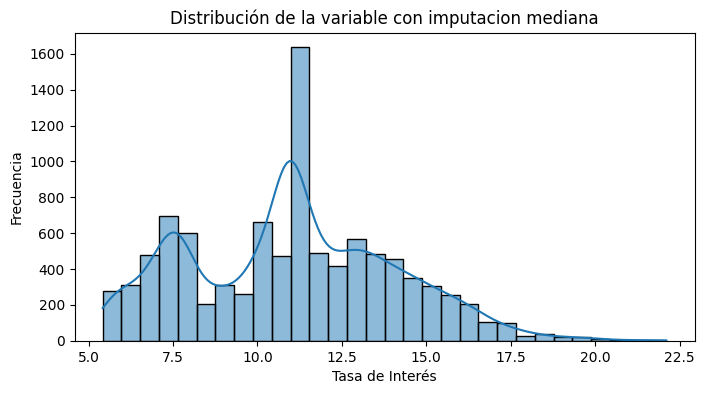

In [27]:
plt.figure(figsize=(8, 4))
sns.histplot(df_integrado_nulls_median['tasa_interes'].dropna(), bins=30, kde=True)
plt.title("Distribución de la variable con imputacion mediana" )
plt.xlabel("Tasa de Interés")
plt.ylabel("Frecuencia")
plt.show()

In [28]:
df_integrado_nulls_groups = df_integrado.copy()

In [29]:
## Imputacion por grupos: considereando otras variables
df_integrado_nulls_groups['tasa_interes'] = df_integrado_nulls_groups.groupby(['duracion_credito',
                            'importe_solicitado', 'limite_credito_tc'])['tasa_interes'].transform(lambda x: x.fillna(x.median()))

In [30]:
display(df_integrado_nulls_groups["tasa_interes"].describe().T, df_integrado["tasa_interes"].describe().T)

count    8949.000000
mean       11.020707
std         3.188160
min         5.420000
25%         7.900000
50%        10.990000
75%        13.470000
max        22.110000
Name: tasa_interes, dtype: float64

count    8878.000000
mean       11.017654
std         3.194046
min         5.420000
25%         7.900000
50%        10.990000
75%        13.470000
max        22.110000
Name: tasa_interes, dtype: float64

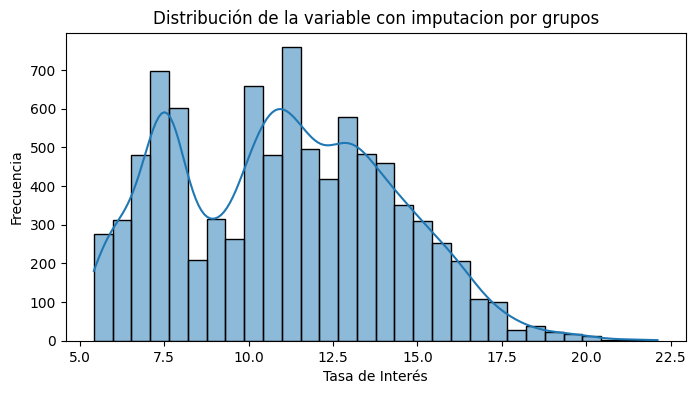

In [31]:
plt.figure(figsize=(8, 4))
sns.histplot(df_integrado_nulls_groups['tasa_interes'].dropna(), bins=30, kde=True)
plt.title("Distribución de la variable con imputacion por grupos" )
plt.xlabel("Tasa de Interés")
plt.ylabel("Frecuencia")
plt.show()

In [32]:
df_integrado_nulls_ml = df_integrado.copy()

In [33]:
# Imputación con ML
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

df_train = df_integrado_nulls_ml.dropna(subset=['tasa_interes'])
df_nulls = df_integrado_nulls_ml[df_integrado_nulls_ml['tasa_interes'].isnull()]

X_train = df_train[['edad', 'importe_solicitado', 'duracion_credito', 'ingresos', 'limite_credito_tc', 'gastos_ult_12m']]
y_train = df_train['tasa_interes']
model = RandomForestRegressor(random_state=1234)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=1234)

In [34]:
# Usar el modelo para predecir los valores nulos de 'tasa_interes'
X_missing = df_nulls[['edad', 'importe_solicitado', 'duracion_credito', 'ingresos', 'limite_credito_tc', 'gastos_ult_12m']]
predicted_tasa_interes = model.predict(X_missing)
df_integrado_nulls_ml.loc[df_integrado_nulls_ml['tasa_interes'].isnull(), 'tasa_interes'] = predicted_tasa_interes


In [35]:
display(df_integrado_nulls_ml["tasa_interes"].describe().T, df_integrado["tasa_interes"].describe().T)

count    9765.000000
mean       11.020592
std         3.071673
min         5.420000
25%         8.490000
50%        10.990000
75%        13.160000
max        22.110000
Name: tasa_interes, dtype: float64

count    8878.000000
mean       11.017654
std         3.194046
min         5.420000
25%         7.900000
50%        10.990000
75%        13.470000
max        22.110000
Name: tasa_interes, dtype: float64

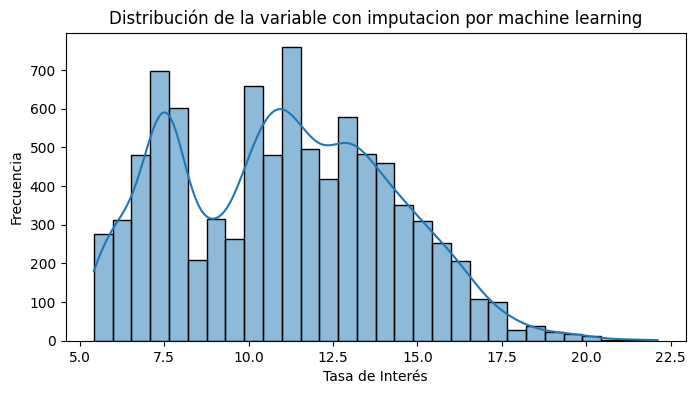

In [36]:
plt.figure(figsize=(8, 4))
sns.histplot(df_integrado_nulls_groups['tasa_interes'].dropna(), bins=30, kde=True)
plt.title("Distribución de la variable con imputacion por machine learning" )
plt.xlabel("Tasa de Interés")
plt.ylabel("Frecuencia")
plt.show()

In [37]:
# Con eliminación de nulos
df_integrado_nulls_dropna = df_integrado[df_integrado["tasa_interes"].isna() == False].copy()

In [38]:
df_integrado_nulls_dropna.isna().sum()

id_cliente                0
edad                      0
importe_solicitado        0
duracion_credito          0
antiguedad_empleado       0
situacion_vivienda        0
ingresos                  0
objetivo_credito          0
pct_ingreso               0
tasa_interes              0
estado_credito            0
falta_pago                0
regla_pct_ingresos        0
regla_duracion_credito    0
antiguedad_cliente        0
estado_civil              0
estado_cliente            0
gastos_ult_12m            0
genero                    0
limite_credito_tc         0
nivel_educativo           0
personas_a_cargo          0
dtype: int64

In [39]:
display(df_integrado_nulls_dropna["tasa_interes"].describe().T, df_integrado["tasa_interes"].describe().T)

count    8878.000000
mean       11.017654
std         3.194046
min         5.420000
25%         7.900000
50%        10.990000
75%        13.470000
max        22.110000
Name: tasa_interes, dtype: float64

count    8878.000000
mean       11.017654
std         3.194046
min         5.420000
25%         7.900000
50%        10.990000
75%        13.470000
max        22.110000
Name: tasa_interes, dtype: float64

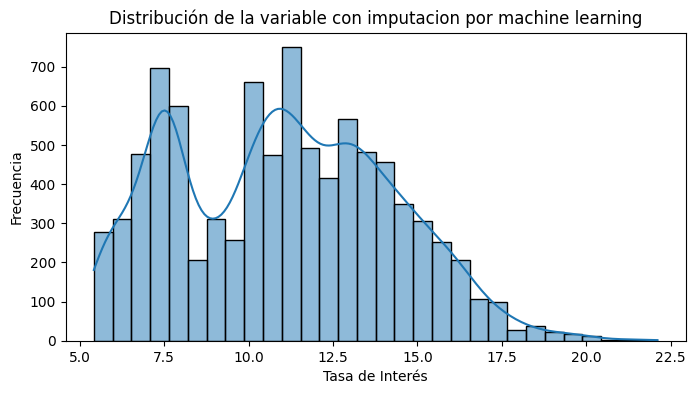

In [40]:
plt.figure(figsize=(8, 4))
sns.histplot(df_integrado_nulls_dropna['tasa_interes'].dropna(), bins=30, kde=True)
plt.title("Distribución de la variable con imputacion por machine learning" )
plt.xlabel("Tasa de Interés")
plt.ylabel("Frecuencia")
plt.show()

##### Columnas categóricas

In [41]:
# Columna: estado_civil
cambios_estado_civil = {
    'CASADO' : 'C',
    'SOLTERO' : 'S',
    'DESCONOCIDO' : 'N',
    'DIVORCIADO' : 'D',
}

estado_civil_N = df_integrado.loc[:, ('estado_civil')].map(cambios_estado_civil).rename('estado_civil_N')

# Columna: estado_credito
cambios_estado_credito = {
    0: 'P',
    1 : 'C',
}
estado_credito_N = df_integrado.loc[:, ('estado_credito')].map(cambios_estado_credito).rename('estado_credito_N')

df_transform = pd.concat([estado_civil_N, estado_credito_N, df_integrado], axis=1)
df_transform.head()

,estado_civil_N,estado_credito_N,id_cliente,edad,importe_solicitado,duracion_credito,antiguedad_empleado,situacion_vivienda,ingresos,objetivo_credito,pct_ingreso,tasa_interes,estado_credito,falta_pago,regla_pct_ingresos,regla_duracion_credito,antiguedad_cliente,estado_civil,estado_cliente,gastos_ult_12m,genero,limite_credito_tc,nivel_educativo,personas_a_cargo
0,C,P,768805383.0,21,1000,2,5.0,PROPIA,9600,EDUCACIÓN,0.10,11.14,0,N,ok,ok,39.0,CASADO,ACTIVO,1144.0,M,12691.0,SECUNDARIO_COMPLETO,3.0
1,C,C,713982108.0,23,35000,2,4.0,ALQUILER,65500,SALUD,0.53,15.23,1,N,ok,ok,36.0,CASADO,ACTIVO,1887.0,M,3418.0,UNIVERSITARIO_COMPLETO,3.0
2,C,C,710821833.0,24,35000,4,8.0,ALQUILER,54400,SALUD,0.55,14.27,1,Y,ok,ok,54.0,CASADO,ACTIVO,1314.0,M,9095.0,DESCONOCIDO,1.0
3,N,C,769911858.0,21,2500,2,2.0,PROPIA,9900,INVERSIONES,0.25,7.14,1,N,ok,ok,34.0,DESCONOCIDO,ACTIVO,1171.0,F,3313.0,SECUNDARIO_COMPLETO,4.0
4,C,C,709106358.0,26,35000,3,8.0,ALQUILER,77100,EDUCACIÓN,0.45,12.42,1,N,ok,ok,21.0,CASADO,ACTIVO,816.0,M,4716.0,UNIVERSITARIO_INCOMPLETO,3.0


In [42]:
df_transform.drop(columns = ["estado_civil", "estado_credito"], inplace = True)

##### Columnas numéricas (discretización)

In [43]:
df_integrado.sample(2)

,id_cliente,edad,importe_solicitado,duracion_credito,antiguedad_empleado,situacion_vivienda,ingresos,objetivo_credito,pct_ingreso,tasa_interes,estado_credito,falta_pago,regla_pct_ingresos,regla_duracion_credito,antiguedad_cliente,estado_civil,estado_cliente,gastos_ult_12m,genero,limite_credito_tc,nivel_educativo,personas_a_cargo
3698,717466158.0,21,1000,3,5.0,HIPOTECA,39000,EDUCACIÓN,0.03,7.49,0,N,ok,ok,40.0,CASADO,ACTIVO,4889.0,F,4176.0,POSGRADO_COMPLETO,2.0
6059,716790633.0,26,6000,4,4.0,ALQUILER,29364,MEJORAS_HOGAR,0.20,13.35,1,Y,ok,ok,36.0,CASADO,PASIVO,1789.0,M,17239.0,UNIVERSITARIO_COMPLETO,3.0


In [44]:
# Antiguedad del empleado

etiquetas_a_e = ['menor_5', '5_a_10', 'mayor_10']
rangos_a_e = [0, 4, 10, 50]
valor_para_nan = 'NA'
antiguedad_empleados_N = pd.cut(df_integrado['antiguedad_empleado'], 
                                bins=rangos_a_e, 
                                labels=etiquetas_a_e,
                                right=False).cat.add_categories(valor_para_nan).fillna(valor_para_nan)

antiguedad_empleados_N.value_counts()

# edad

etiquetas_e = ['menor_25', '25_a_30']
rangos_e = [0, 24, 50]
edad_N = pd.cut(df_integrado['edad'], 
                                bins=rangos_e, 
                                labels=etiquetas_e)

edad_N.value_counts()

# pct_ingreso

etiquetas_p_i = ['hasta_20', '20_a_40', '40_a_60', 'mayor_60']
rangos_p_i = [0, 0.19, 0.39, 0.60, 0.99]
pct_ingreso_N = pd.cut(df_integrado['pct_ingreso'], 
                                bins=rangos_p_i, 
                                labels=etiquetas_p_i)

pct_ingreso_N.value_counts()

# ingresos

etiquetas_i = ['hasta_20k', '20k_a_50k', '50k_a_100k', 'mayor_100k']
rangos_i = [0, 19999, 49999, 99999, 999999]
ingresos_N = pd.cut(df_integrado['ingresos'], 
                                bins=rangos_i, 
                                labels=etiquetas_i)

ingresos_N.value_counts()

# tasa_interes

etiquetas_t_i = ['hasta_7p', '7p_a_15p', '15p_a_20p', 'mayor_20p']
rangos_t_i = [0, 6.99, 14.99, 19.99, 100]
tasa_interes_N = pd.cut(df_integrado['tasa_interes'], 
                                bins=rangos_t_i, 
                                labels=etiquetas_t_i)

tasa_interes_N.value_counts()

# antiguedad_cliente

etiquetas_a_c = ['menor_2y', '2y_a_4y', 'mayor_4y']
rangos_a_c = [0, 24, 48, 100]
antiguedad_cliente_N = pd.cut(df_integrado['antiguedad_cliente'], 
                                bins=rangos_a_c, 
                                labels=etiquetas_a_c)

antiguedad_cliente_N.value_counts()

# limite_credito_tc

etiquetas_l_tc = ['menor_3k', '3k_a_5k', '5k_a_10k', 'mayor_10k']
rangos_l_tc = [0, 2999, 4999, 9999, 100000]
limite_credito_tc_N = pd.cut(df_integrado['limite_credito_tc'], 
                                bins=rangos_l_tc, 
                                labels=etiquetas_l_tc)

limite_credito_tc_N.value_counts()

# gastos_ult_12m

etiquetas_g_u12 = ['menor_1k', '2k_a_4k', '4k_a_6k', '6k_a_8k', '8k_a_10k', 'mayor_10k']
rangos_g_u12 = [0, 999, 3999, 5999, 7999, 9999, 100000]
gastos_ult_12m_N = pd.cut(df_integrado['gastos_ult_12m'], 
                                bins=rangos_g_u12, 
                                labels=etiquetas_g_u12)

gastos_ult_12m_N.value_counts()

gastos_ult_12m
2k_a_4k      4907
4k_a_6k      3291
mayor_10k     742
6k_a_8k       351
8k_a_10k      320
menor_1k      154
Name: count, dtype: int64

In [45]:
df_integrado.sample(3)

,id_cliente,edad,importe_solicitado,duracion_credito,antiguedad_empleado,situacion_vivienda,ingresos,objetivo_credito,pct_ingreso,tasa_interes,estado_credito,falta_pago,regla_pct_ingresos,regla_duracion_credito,antiguedad_cliente,estado_civil,estado_cliente,gastos_ult_12m,genero,limite_credito_tc,nivel_educativo,personas_a_cargo
5936,715532208.0,24,3500,3,2.0,HIPOTECA,42000,PAGO_DEUDAS,0.08,8.94,1,N,ok,ok,55.0,SOLTERO,ACTIVO,3807.0,F,4010.0,SECUNDARIO_COMPLETO,1.0
7113,718816158.0,23,6600,2,3.0,ALQUILER,48000,EDUCACIÓN,0.14,11.11,0,N,ok,ok,33.0,SOLTERO,ACTIVO,3851.0,F,5362.0,SECUNDARIO_COMPLETO,3.0
7983,717553683.0,26,7500,3,2.0,ALQUILER,45450,SALUD,0.17,11.14,0,N,ok,ok,36.0,CASADO,ACTIVO,4608.0,F,3040.0,DESCONOCIDO,1.0


In [46]:
col_eliminar_final = [
              'edad',
              'antiguedad_empleado',
              'antiguedad_cliente', 
              'ingresos',
              'pct_ingreso', 
              'tasa_interes',
              'regla_pct_ingresos',
              'gastos_ult_12m', 
              'limite_credito_tc', 
              'id_cliente']

df_transform.drop(col_eliminar_final, inplace=True, axis=1)

df_final = pd.concat([ gastos_ult_12m_N, 
                      limite_credito_tc_N, 
                      antiguedad_cliente_N, 
                      tasa_interes_N, 
                      ingresos_N, 
                      pct_ingreso_N, 
                      antiguedad_empleados_N, 
                      edad_N, 
                      df_transform], axis=1)
df_final.head(5)

,gastos_ult_12m,limite_credito_tc,antiguedad_cliente,tasa_interes,ingresos,pct_ingreso,antiguedad_empleado,edad,estado_civil_N,estado_credito_N,importe_solicitado,duracion_credito,situacion_vivienda,objetivo_credito,falta_pago,regla_duracion_credito,estado_cliente,genero,nivel_educativo,personas_a_cargo
0,2k_a_4k,mayor_10k,2y_a_4y,7p_a_15p,hasta_20k,hasta_20,5_a_10,menor_25,C,P,1000,2,PROPIA,EDUCACIÓN,N,ok,ACTIVO,M,SECUNDARIO_COMPLETO,3.0
1,2k_a_4k,3k_a_5k,2y_a_4y,15p_a_20p,50k_a_100k,40_a_60,5_a_10,menor_25,C,C,35000,2,ALQUILER,SALUD,N,ok,ACTIVO,M,UNIVERSITARIO_COMPLETO,3.0
2,2k_a_4k,5k_a_10k,mayor_4y,7p_a_15p,50k_a_100k,40_a_60,5_a_10,menor_25,C,C,35000,4,ALQUILER,SALUD,Y,ok,ACTIVO,M,DESCONOCIDO,1.0
3,2k_a_4k,3k_a_5k,2y_a_4y,7p_a_15p,hasta_20k,20_a_40,menor_5,menor_25,N,C,2500,2,PROPIA,INVERSIONES,N,ok,ACTIVO,F,SECUNDARIO_COMPLETO,4.0
4,menor_1k,3k_a_5k,menor_2y,7p_a_15p,50k_a_100k,40_a_60,5_a_10,25_a_30,C,C,35000,3,ALQUILER,EDUCACIÓN,N,ok,ACTIVO,M,UNIVERSITARIO_INCOMPLETO,3.0


In [47]:
print(f"Cantidad de columnas del dataset final: {df_final.shape[1]}")
print(f"Cantidad de filas del dataset final: {df_final.shape[0]}")

Cantidad de columnas del dataset final: 20
Cantidad de filas del dataset final: 9765


In [52]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9765 entries, 0 to 9764
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   gastos_ult_12m          9765 non-null   category
 1   limite_credito_tc       9765 non-null   category
 2   antiguedad_cliente      9765 non-null   category
 3   tasa_interes            8878 non-null   category
 4   ingresos                9765 non-null   category
 5   pct_ingreso             9765 non-null   category
 6   antiguedad_empleado     9765 non-null   category
 7   edad                    9765 non-null   category
 8   estado_civil_N          9765 non-null   object  
 9   estado_credito_N        9765 non-null   object  
 10  importe_solicitado      9765 non-null   int64   
 11  duracion_credito        9765 non-null   int64   
 12  situacion_vivienda      9765 non-null   object  
 13  objetivo_credito        9765 non-null   object  
 14  falta_pago              

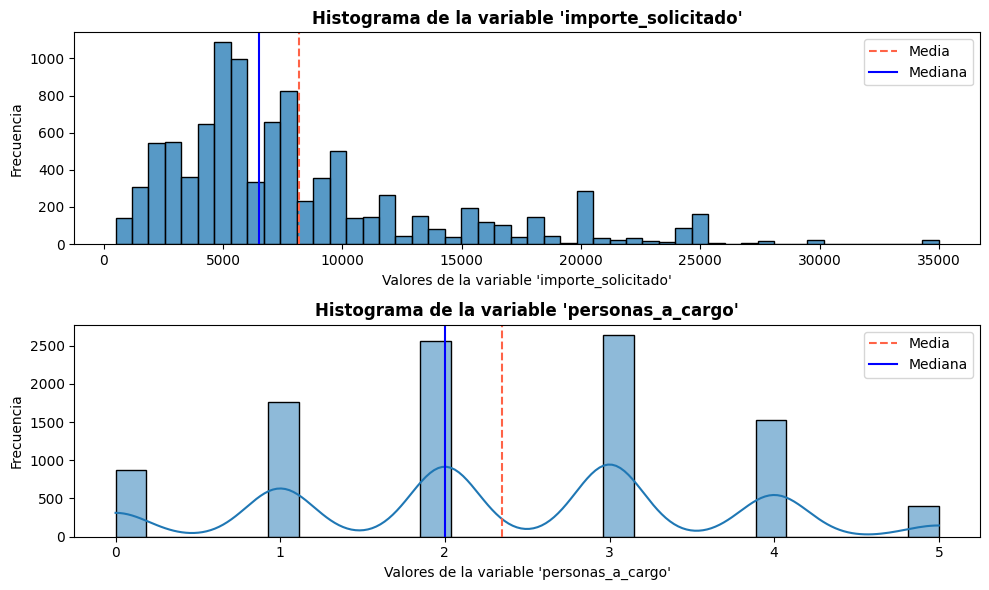

In [54]:
numericas_df_final = df_final.drop(columns = ["duracion_credito"]).select_dtypes(include=['float64', 'int64']).columns
numero_columnass = len(numericas_df_final)
plt.figure(figsize=(10, numero_columnass * 3))  

for index, col in enumerate(numericas_df_final, start=1):
    plt.subplot(numero_columnass, 1, index)
    titulo = f"Histograma de la variable '{col}'"
    texto_ejex = f"Valores de la variable '{col}'"
    
    if df_final[col].dtype == 'float64':
        sns.histplot(df_final[col], kde=True)
    elif df_creditos[col].dtype == 'int64':
        sns.histplot(df_final[col], kde=False, bins=50)
        
    plt.axvline(df_final[col].mean(), color='tomato', linestyle='--', label='Media') # PAra media
    plt.axvline(df_final[col].median(), color='blue', linestyle='-', label='Mediana') # Para mediana
    plt.title(titulo, weight='bold')
    plt.xlabel(texto_ejex)
    plt.ylabel("Frecuencia")
    plt.legend()

plt.tight_layout()
plt.show()

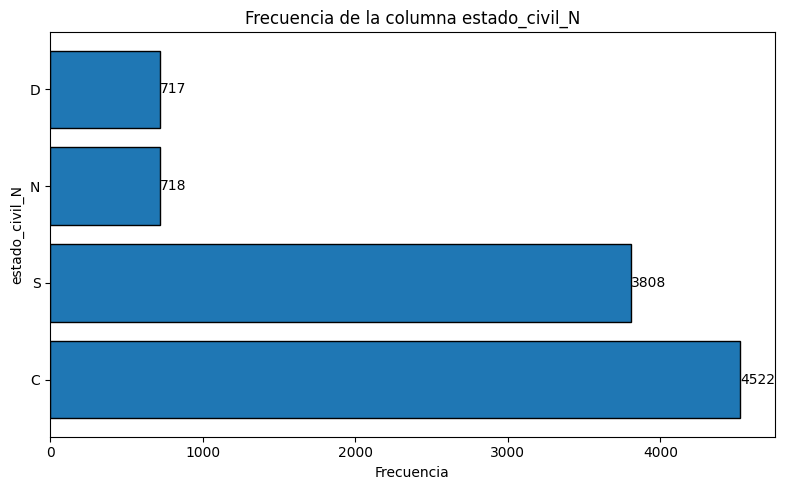

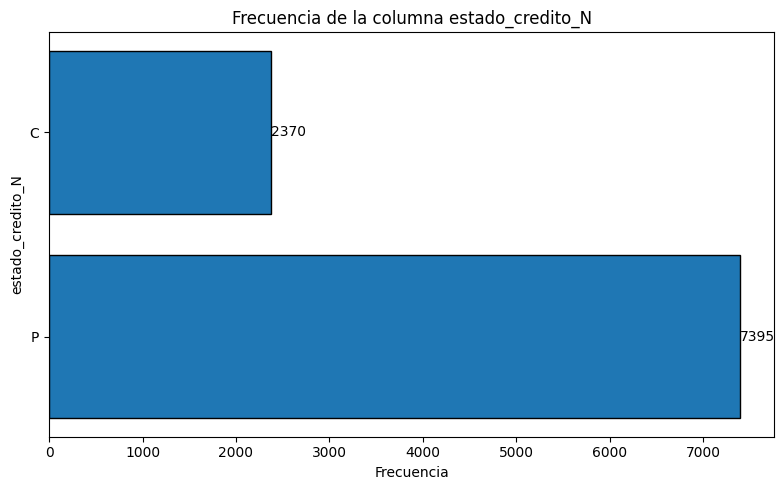

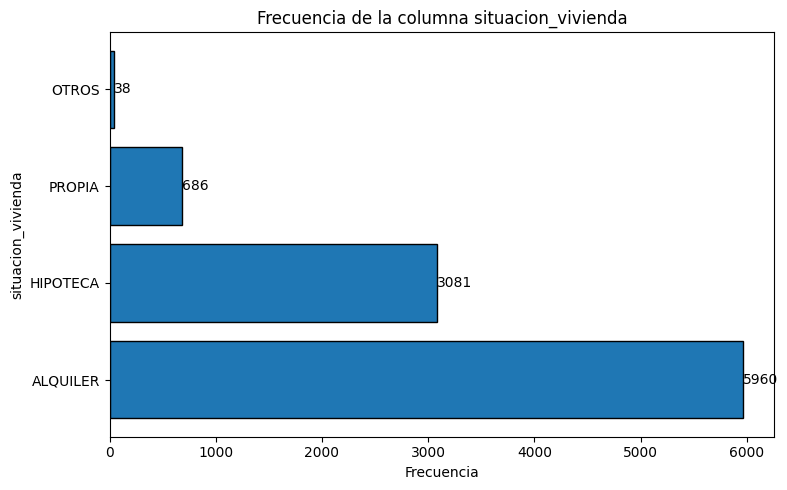

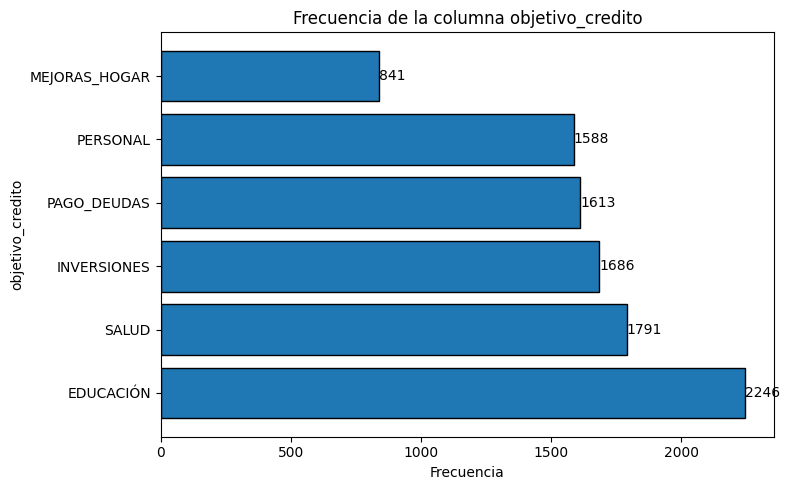

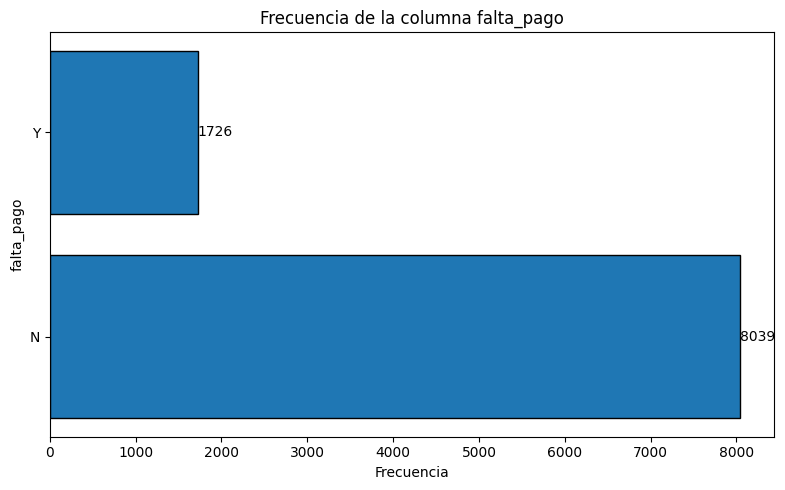

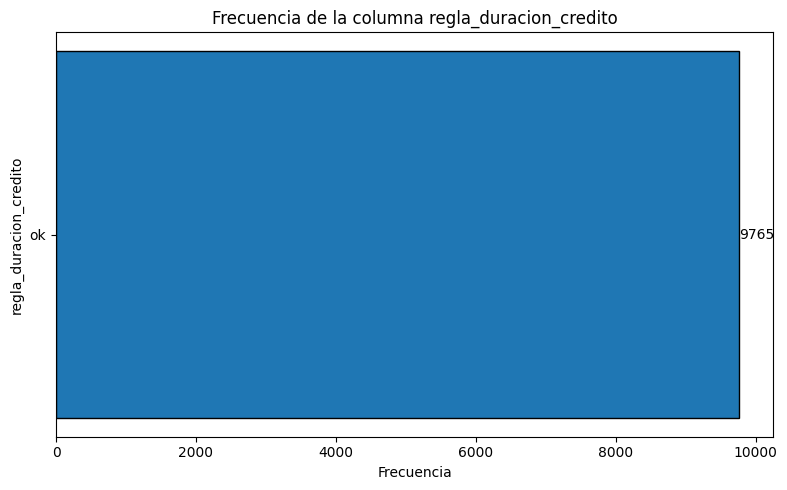

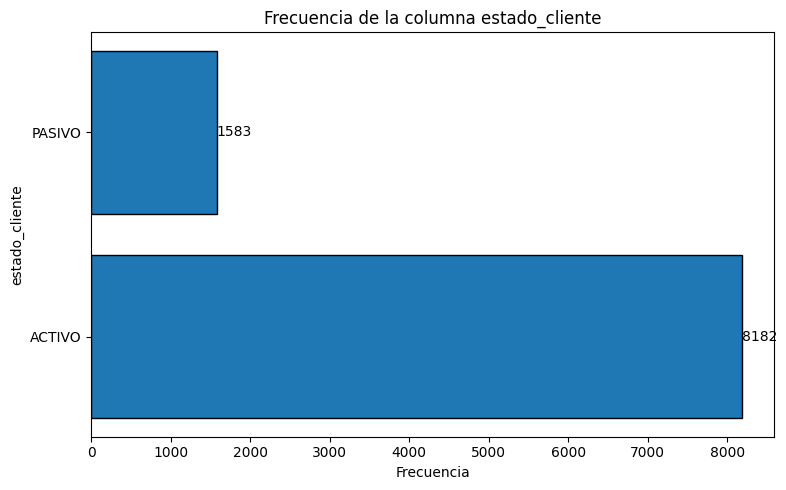

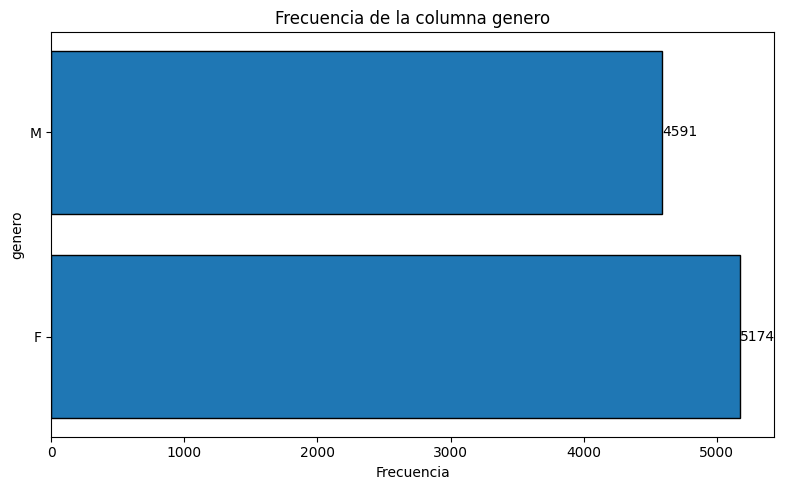

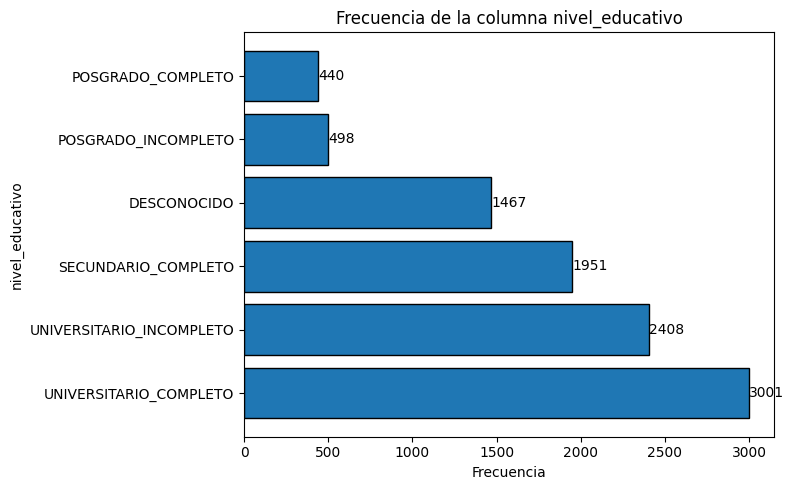

In [55]:
categoricas_df_final = df_final.select_dtypes(include='object').columns.tolist()
for col in categoricas_df_final:
    plt.figure(figsize=(8, 5))
    aux_dict = df_final[col].value_counts().to_dict()
    y = list(aux_dict.values())
    plt.barh(*zip(*aux_dict.items()), edgecolor='black')
    for index, value in enumerate(y):
        plt.text(value, index, str(value), va='center')
    plt.title(f'Frecuencia de la columna {col}')
    plt.xlabel('Frecuencia')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

In [49]:
df_final.to_csv("../../data/final/datos_finales.csv", sep=';', index=False)